In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"apollopubg","key":"3c6e2519fa3fc29b6143e88f14a90408"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d ctrlintelligencrcui/rnsa-subset-58kpngs
! unzip rnsa-subset-58kpngs.zip

In [5]:
import os
import time
import shutil
import pathlib
import itertools
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from PIL import Image
import os, random, shutil
from random import uniform
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
from tensorflow.keras.models import Model,load_model, Sequential
from tensorflow.keras.layers import  GlobalAveragePooling2D, Dropout, Dense, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers


In [7]:
dataset_path = 'RNSA-5K-PNGs'
# ! rm 'RNSA_Subset_PNGs_12K/Meta data.txt'
folders = [os.path.join(dataset_path, folder_name) for folder_name in os.listdir(dataset_path)]

# Initialize empty lists to store the file paths for each set
train_set, validation_set, test_set = [], [], []

# Loop over each folder and split the PNG images into sets
for folder in folders:
    # Get the folder name (label)
    folder_name = os.path.basename(folder)
    # Get a list of all the PNG images in the folder
    png_images = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.png')]
    random.shuffle(png_images)
    # Define the percentage split for train, validation, and test sets
    train_percent, validation_percent, test_percent = 0.75, 0.15, 0.1
    # Split the PNG images into train, validation, and test sets
    num_files = len(png_images)
    train_end = int(num_files * train_percent)
    validation_end = int(num_files * (train_percent + validation_percent))
    train_set += png_images[:train_end]
    validation_set += png_images[train_end:validation_end]
    test_set += png_images[validation_end:]

for directory in ['Train', 'Validation', 'Test']:
    os.makedirs(os.path.join(dataset_path, directory), exist_ok=True)


# Loop over the train, validation, and test sets, and copy each image to the appropriate directory
for set_name, set_files in [('Train', train_set), ('Validation', validation_set), ('Test', test_set)]:
    for folder_name in ['Any_Positive', 'epidural_positive','intraparenchymal_positvie', 'intraventricular_positive', 'subarachnoid_positive', 'subdural_positive', "Any_Normal"]:
        # Create the folder in the set directory
        os.makedirs(os.path.join(dataset_path, set_name, folder_name), exist_ok=True)
        # Get the images in the current folder
        folder_files = [f for f in set_files if folder_name in f]
        # Copy the images to the set directory
        for f in folder_files:
            dest_folder = os.path.join(dataset_path, set_name, folder_name)
            shutil.copy(f, dest_folder)

# Print the number of images in each set
print("Train set size:", len(train_set))
print("Validation set size:", len(validation_set))
print("Test set size:", len(test_set))

Train set size: 43608
Validation set size: 8722
Test set size: 5815


Found 26373 images belonging to 7 classes.
Found 6631 images belonging to 7 classes.
Found 4549 images belonging to 7 classes.


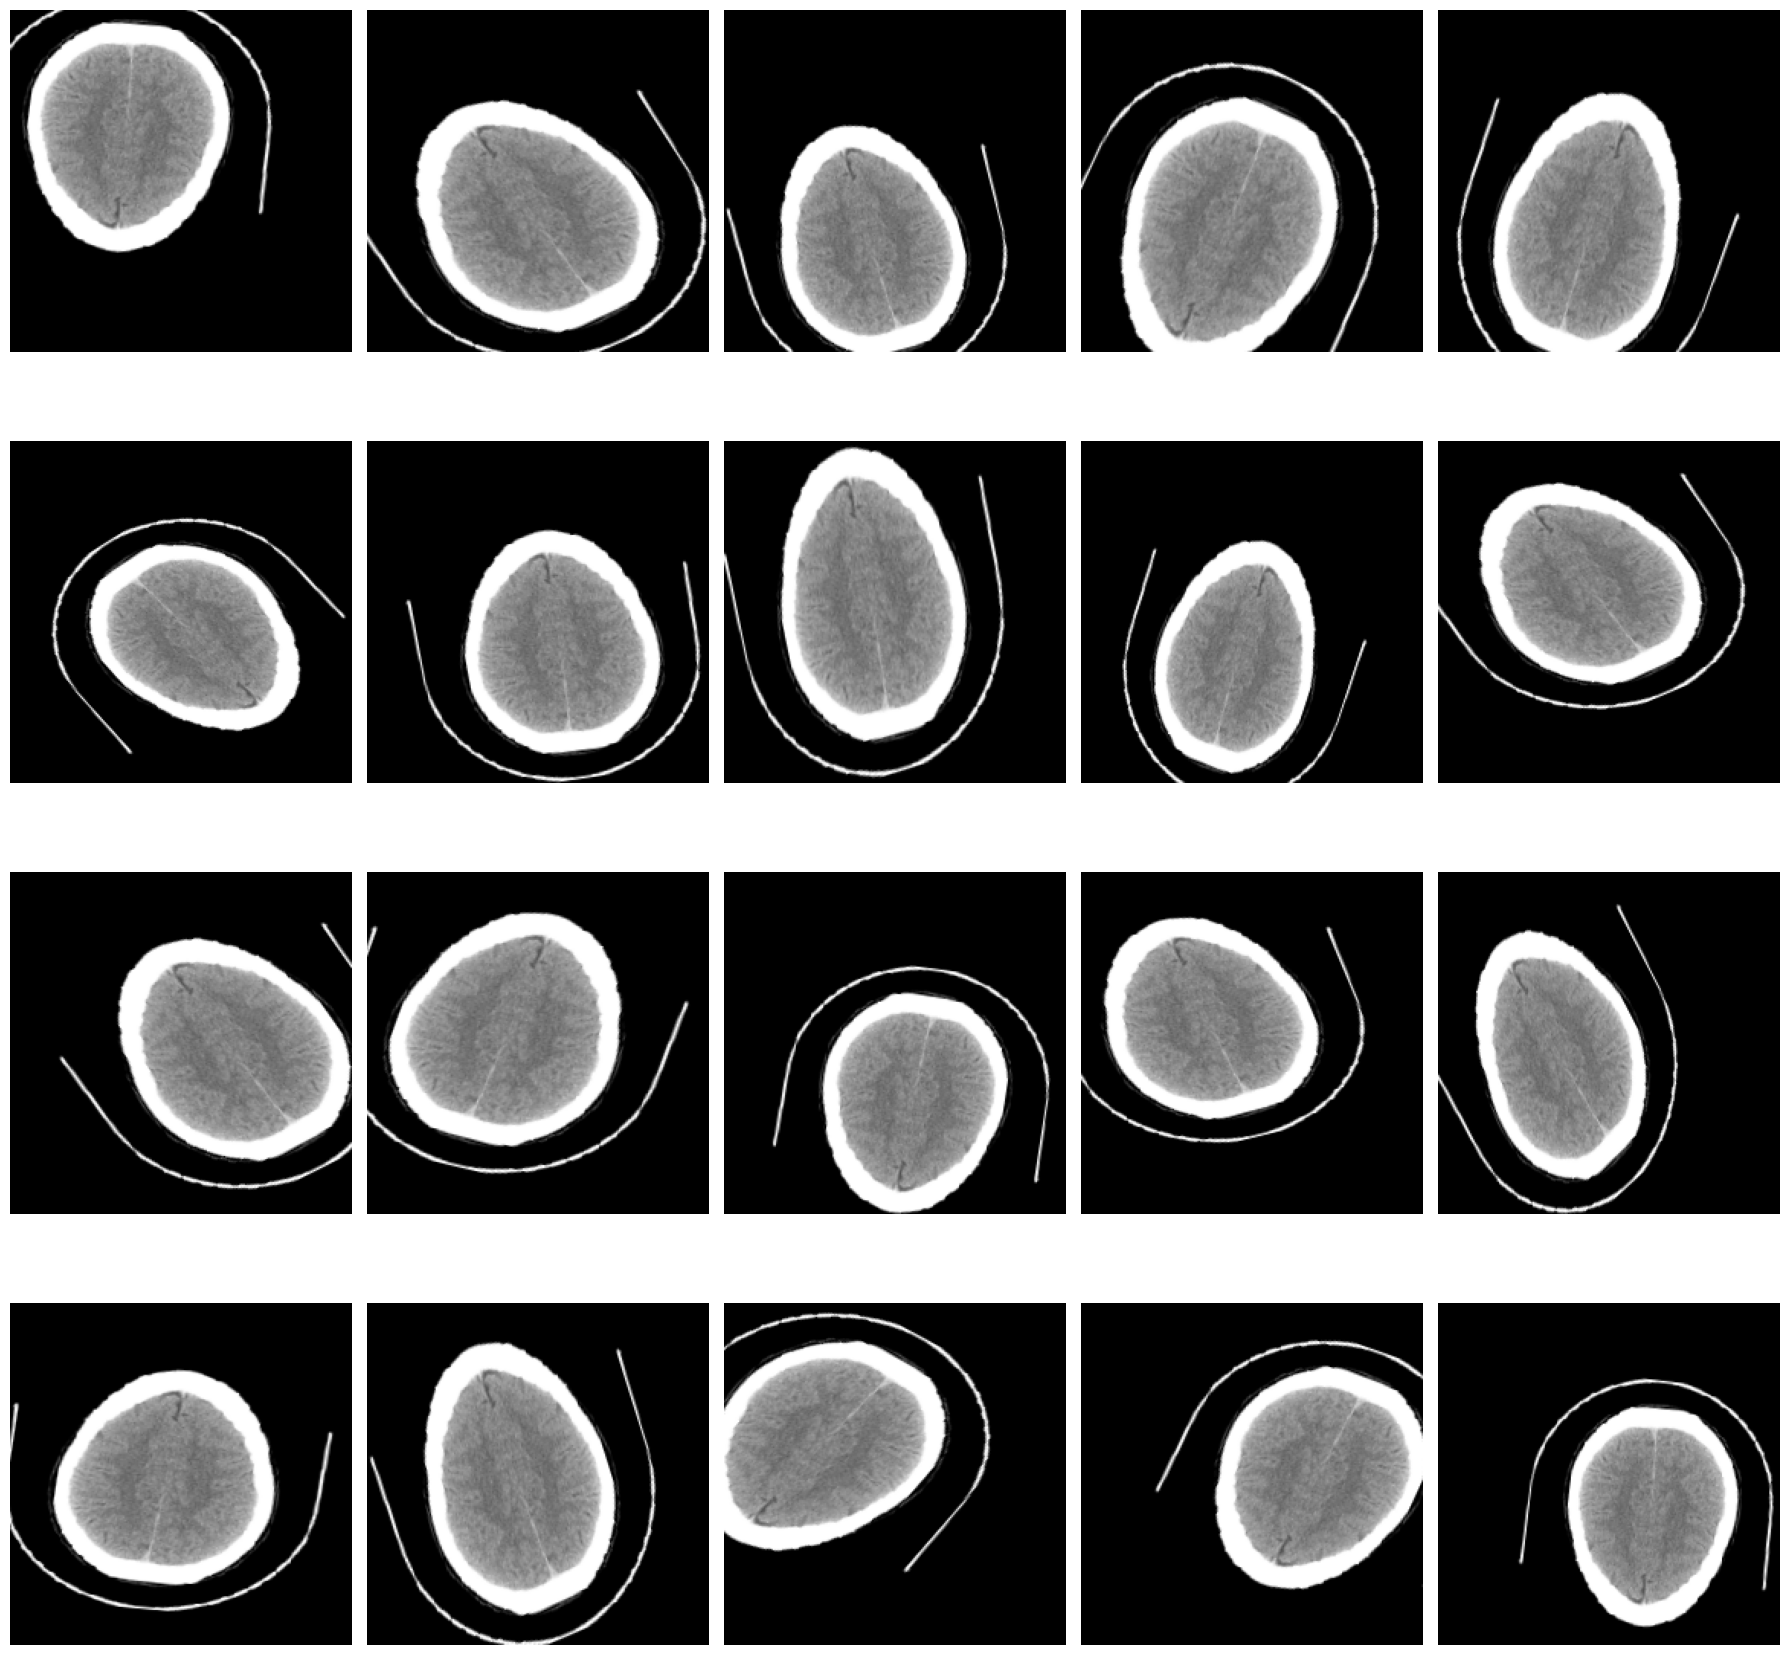

In [8]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
)

train_generator = datagen.flow_from_directory(
    "RNSA-5K-PNGs/Train",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)


valid_generator = val_gen.flow_from_directory(
    "RNSA-5K-PNGs/Validation",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
)
test_generator = val_gen.flow_from_directory(
    "RNSA-5K-PNGs/Test",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
)


def plotImages(images_arr):
    fig, axes = plt.subplots(4, 5, figsize=(18,18))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_generator[0][0][0] for i in range(20)]
plotImages(augmented_images)


In [9]:
base_model = ResNet50(weights= 'imagenet', include_top=False, input_shape= (224, 224, 3))
resnet = base_model.output
resnet = GlobalAveragePooling2D()(resnet)
resnet = Dropout(0.25)(resnet)
predictions = Dense(7, activation= 'softmax')(resnet)
Resnet50 = Model(inputs = base_model.input, outputs = predictions)

94765736/94765736 [==============================] - 5s 0us/step


In [10]:
METRICS = [tf.keras.metrics.AUC(name='accuracy')]

In [11]:
adam = Adam(learning_rate = 0.0001)
Resnet50.compile(optimizer= adam, loss='categorical_crossentropy', metrics=METRICS)

In [12]:
History = Resnet50.fit(train_generator,  epochs = 20,  validation_data = (valid_generator))

Epoch 1/20
825/825 [==============================] - 468s 505ms/step - loss: 1.6778 - accuracy: 0.7344 - val_loss: 1.7028 - val_accuracy: 0.7541
Epoch 2/20
825/825 [==============================] - 418s 506ms/step - loss: 1.5381 - accuracy: 0.7847 - val_loss: 1.3418 - val_accuracy: 0.8399
Epoch 3/20
825/825 [==============================] - 411s 498ms/step - loss: 1.4859 - accuracy: 0.8022 - val_loss: 1.3771 - val_accuracy: 0.8309
Epoch 4/20
825/825 [==============================] - 408s 493ms/step - loss: 1.4545 - accuracy: 0.8120 - val_loss: 1.3063 - val_accuracy: 0.8515
Epoch 5/20
825/825 [==============================] - 408s 494ms/step - loss: 1.4285 - accuracy: 0.8199 - val_loss: 1.2745 - val_accuracy: 0.8589
Epoch 6/20
825/825 [==============================] - 413s 500ms/step - loss: 1.4066 - accuracy: 0.8260 - val_loss: 1.3406 - val_accuracy: 0.8483
Epoch 7/20
825/825 [==============================] - 430s 521ms/step - loss: 1.3879 - accuracy: 0.8312 - val_loss: 1.3087 -

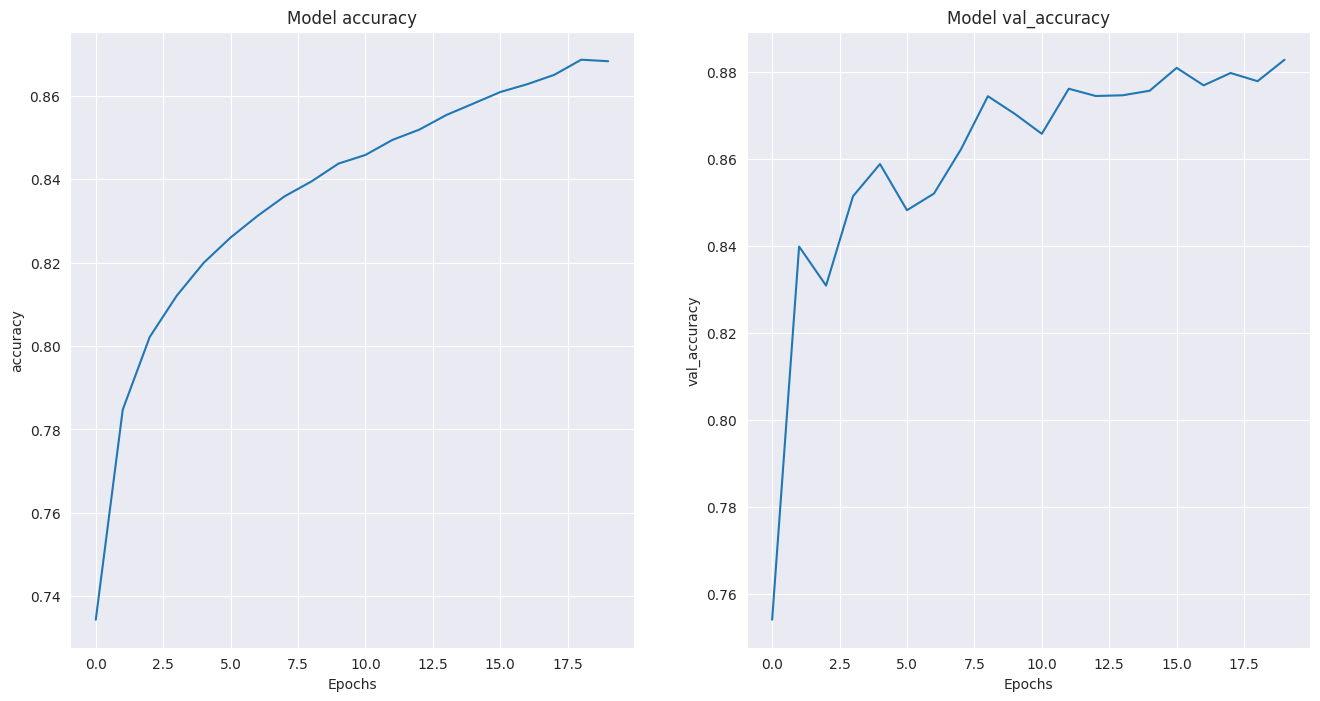

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (16, 8))
ax = ax.ravel()

for i, metric in enumerate(["accuracy","val_accuracy"]):
    ax[i].plot(History.history[metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)

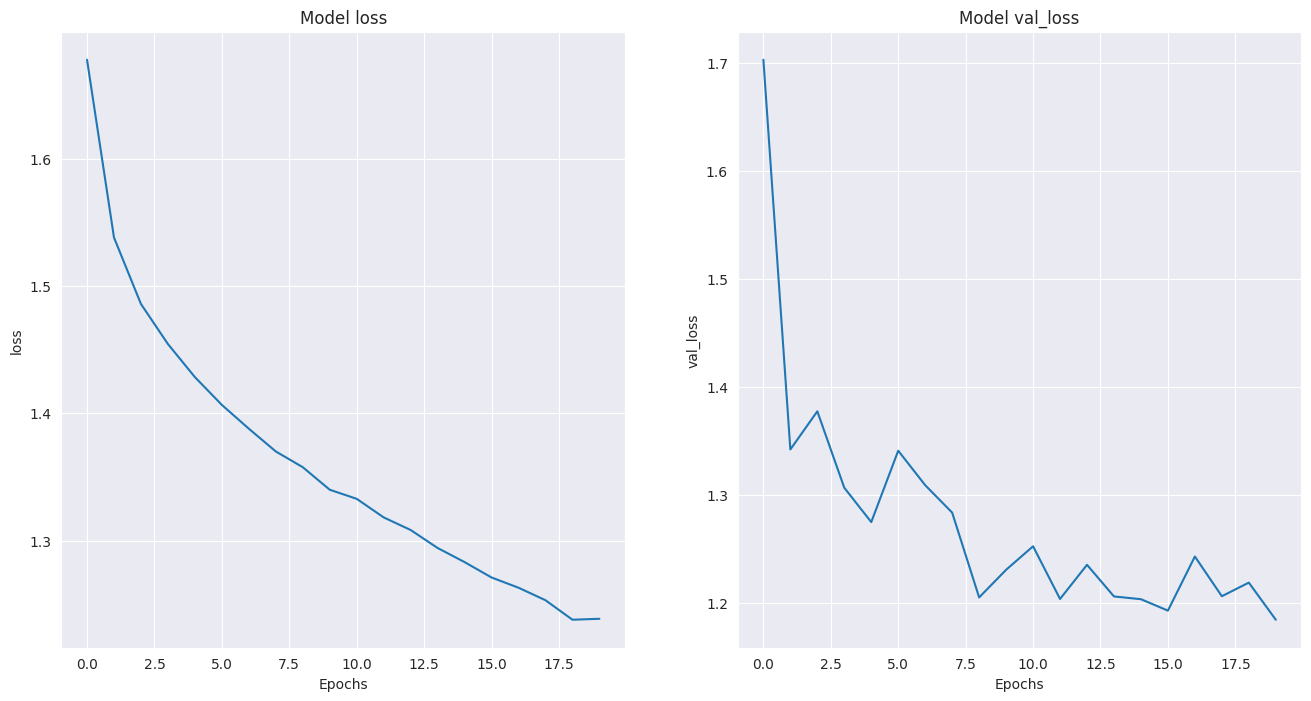

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (16, 8))
ax = ax.ravel()

for i, metric in enumerate([ "loss","val_loss"]):
    ax[i].plot(History.history[metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)

In [15]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
classes = list(test_generator.class_indices.keys())
classes

['Any_Positive',
 'epidural_positive',
 'intraparenchymal_positvie',
 'intraventricular_positive',
 'normal',
 'subarachnoid_positive',
 'subdural_positive']

143/143 [==============================] - 18s 106ms/step
Classification Report
                           precision    recall  f1-score   support

             Any_Positive       0.00      0.00      0.00       500
        epidural_positive       0.08      0.11      0.09       315
intraparenchymal_positvie       0.09      0.08      0.08       500
intraventricular_positive       0.11      0.16      0.13       500
                   normal       0.38      0.38      0.38      1734
    subarachnoid_positive       0.11      0.10      0.10       500
        subdural_positive       0.12      0.19      0.15       500

                 accuracy                           0.21      4549
                macro avg       0.13      0.14      0.13      4549
             weighted avg       0.20      0.21      0.20      4549



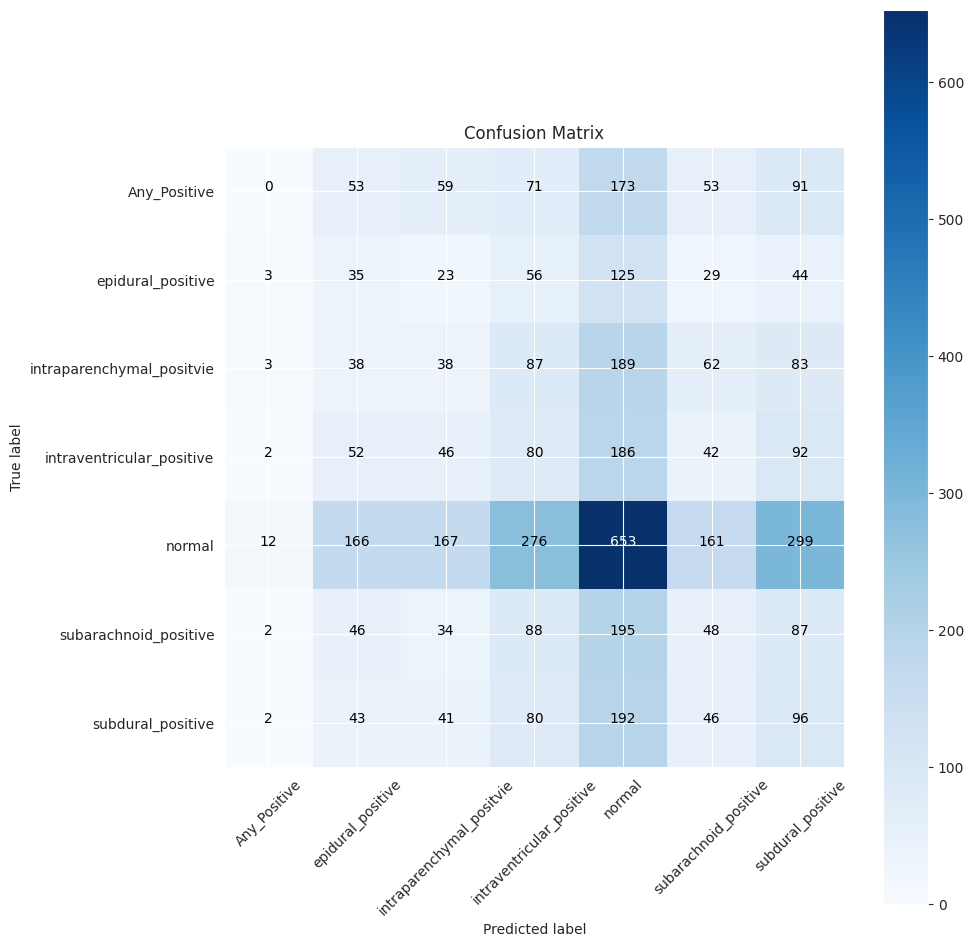

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
#Confution Matrix and Classification Report
Y_pred = Resnet50.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))